In [ ]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
from typing import Tuple, Union

import torch.nn.functional as F
from torch import Tensor
import torch.nn as nn
from torch.nn import GRU, Linear, ReLU, Tanh, Sigmoid, LeakyReLU, Sequential, BatchNorm1d, Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import  global_mean_pool, global_max_pool, global_add_pool, CGConv, GraphConv, GCNConv, GATConv, GPSConv, GINEConv, BatchNorm, LayerNorm
from torch_geometric.data import Dataset, Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj, OptTensor, PairTensor

from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from IPython.display import Image
import imageio
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


#### Get Materials Project data (processed in the SchNet baseline notebook, obtained from SchNetPack). Already stored as DataLoaders.

In [ ]:
train_loader_32 = torch.load("/drive/My Drive/train_loader_32.pth")
test_loader_32 = torch.load("/drive/My Drive/test_loader_32.pth")
val_loader_32 = torch.load("/drive/My Drive/val_loader_32.pth")
train_loader_64 = torch.load("/drive/My Drive/train_loader_64.pth")
test_loader_64 = torch.load("/drive/My Drive/test_loader_64.pth")
val_loader_64 = torch.load("/drive/My Drive/val_loader_64.pth")

In [ ]:
train_loader_32_15k = torch.load("/drive/My Drive/train_loader_32-15k.pth")
test_loader_32_15k = torch.load("/drive/My Drive/test_loader_32-15k.pth")
val_loader_32_15k = torch.load("/drive/My Drive/val_loader_32-15k.pth")
train_loader_64_15k = torch.load("/drive/My Drive/train_loader-64-15k.pth")
test_loader_64_15k = torch.load("/drive/My Drive/test_loader_64-15k.pth")
val_loader_64_15k = torch.load("/drive/My Drive/val_loader_64-15k.pth")

# Baseline Training Code

Here I'm training the best NAS model from experiments which corresponds to the sequence (TOCHECK: Vocabulary has since changed after incorporating additional layers/activations). I'm doing things manually here as a sanity check to ensure I get the same result as with the NAS constructor. Contains training functions also used later in NAS section. 

In [ ]:
class ManualGNN(torch.nn.Module):
    """
    Manual GNN Constructor for debugging purposes
    """
    def __init__(self):

        super().__init__()
        self.lin0 = torch.nn.Linear(1, dim)

        self.bn = BatchNorm(dim)
        self.ln = LayerNorm(dim)

        ### Block 1 GC Layers
        self.conv1 = CGConv(dim, 1, aggr='add')
        self.conv2 = GATConv(dim, dim, aggr='mean')
        self.conv3 = CGConv(dim, 1, aggr='mean')

        ### Block 2 GC Layers (only 2, first one is another dense --> 14)
        self.lin3 = torch.nn.Linear(dim, dim)
        self.conv4 = GATConv(dim, dim, aggr='mean')
        self.conv5 = GraphConv(dim, dim, aggr='max')

        ################ Tests with Graph Transformer layers ##################
        
        # NOT PART OF NAS EXPERIMENTS. JUST TO SEE IF THEY COULD BE INCORPORATED 
        # TO SEARCH SPACE EVENTUALLY.

        #self.node_emb = Embedding(100, dim)
        #self.edge_emb = Embedding(8, dim)
        
        #nn = Sequential(
            #Linear(dim, dim),
            #ReLU(),
            #Linear(dim, dim),
        #)

        #self.conv2 = GPSConv(dim, GINEConv(nn), heads=1, attn_dropout=0.5)
        #self.conv2 = TransformerConv(dim, dim)

        #######################################################################

        self.lin1 = torch.nn.Linear(dim, dim)
        self.lin2 = torch.nn.Linear(dim*2, 1) # concat

    def forward(self, data):

        out1 = F.relu(self.lin0(data.x))

        out1 = F.relu(self.conv1(out1, data.edge_index, data.edge_attr))
        out1 = F.silu(self.conv2(out1, data.edge_index, data.edge_attr))
        out1 = self.ln(F.silu(self.conv3(out1, data.edge_index, data.edge_attr)))

        # Transformer/GPSConv layers give out memory errors 
        #x = self.node_emb(data.x.squeeze(-1).long()) 
        #edge_attr = self.edge_emb(data.edge_attr.long())
        #out = self.conv2(x, data.edge_index, data.batch, edge_attr=edge_attr)

        out1 = global_mean_pool(out1, data.batch)
        out1 = F.relu(self.lin1(out1))

        # BLOCK 2
        out2 = F.relu(self.lin0(data.x))
        out2 = self.ln(F.silu(self.conv4(out2, data.edge_index, data.edge_attr)))
        out2 = self.bn(self.conv5(out2, data.edge_index, data.edge_attr))
        out2 = global_max_pool(out2, data.batch)
        out2 = F.relu(self.lin1(out2))

        out = torch.cat((out1, out2), dim=1)
        out = self.lin2(out)

        return out.view(-1)


dim = 64 # 4 in sequence
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ManualGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5,
                                                       min_lr=0.00001)

#Train and test functions
def train(model, train_loader, force_training):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        e = model(data)
        if force_training:
          f_pred = -1*torch.autograd.grad(
              outputs=e,
              inputs=data.pos,
              grad_outputs=torch.ones_like(e),
              create_graph=True, retain_graph = True,
          )[0]
          #loss = ef_loss(e, data.y, f_pred, data.force)
        else:
          loss = F.l1_loss(model(data), data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(model, test_loader, force_training):
    model.eval()
    loss_all = 0
    predicted_energies = []
    predicted_forces = []

    for data in test_loader:
        data = data.to(device)
        e = model(data)
        if force_training:
          f_pred = -1*torch.autograd.grad(
              outputs=e,
              inputs=data.pos,
              grad_outputs=torch.ones_like(e),
              create_graph=True, retain_graph = True,
          )[0]
          #loss = ef_loss(e, data.y, f_pred, data.force)
        else:
          loss = F.l1_loss(model(data), data.y)
        loss_all += loss.item() * data.num_graphs
        predicted_energies.append(model(data).cpu().detach().numpy())
    
    if force_training: return loss_all / len(test_loader.dataset), predicted_energies, predicted_forces
    else: return loss_all / len(test_loader.dataset), predicted_energies


def train_architecture(model, batch_size, epochs):

    #if batch_size == 32: train_loader, test_loader, val_loader = train_loader_32, test_loader_32, val_loader_32
    #else: train_loader, test_loader, val_loader = train_loader_64, test_loader_64, val_loader_64
  
    if batch_size == 32: train_loader, test_loader, val_loader = train_loader_32_15k, test_loader_32_15k, val_loader_32_15k
    else: train_loader, test_loader, val_loader = train_loader_64_15k, test_loader_64_15k, val_loader_64_15k

    best_val_error = None
    losses = []
    val_errors = []
    for epoch in range(1, epochs+1):
        lr = scheduler.optimizer.param_groups[0]['lr']
        loss = train(model, train_loader, force_training=False)
        val_error, _ = test(model, val_loader, force_training=False)
        scheduler.step(val_error)
        losses.append(loss)
        val_errors.append(val_error)

        if best_val_error is None or val_error <= best_val_error:
            test_error = test(model, test_loader, force_training=False)
            best_val_error = val_error

        print(f'Epoch: {epoch:03d}, LR: {lr:7f}, Loss: {loss:.7f},' f'Val MAE: {val_error:.7f}')
        
    return best_val_error, val_errors, losses

batch_size = 32 # 3 in sequence
epochs = 300
best_test_error, val_errors, losses = train_architecture(model, batch_size, epochs)
res = (best_test_error, val_errors, losses)
path = '/drive/My Drive/best-arch-log.txt'  
with open(path, 'w') as file:
    file.write(str(res))
    file.close()

Epoch: 001, LR: 0.005000, Loss: 0.6798764,Val MAE: 0.5311316
Epoch: 002, LR: 0.005000, Loss: 0.6512375,Val MAE: 0.5130473
Epoch: 003, LR: 0.005000, Loss: 0.6234020,Val MAE: 0.4937561
Epoch: 004, LR: 0.005000, Loss: 0.6033430,Val MAE: 0.4935280
Epoch: 005, LR: 0.005000, Loss: 0.5966609,Val MAE: 0.4854446
Epoch: 006, LR: 0.005000, Loss: 0.5790288,Val MAE: 0.5059482
Epoch: 007, LR: 0.005000, Loss: 0.5765331,Val MAE: 0.5055641
Epoch: 008, LR: 0.005000, Loss: 0.5696208,Val MAE: 0.5652311
Epoch: 009, LR: 0.005000, Loss: 0.5510450,Val MAE: 0.5662478
Epoch: 010, LR: 0.005000, Loss: 0.5453686,Val MAE: 0.5127113
Epoch: 011, LR: 0.005000, Loss: 0.5347080,Val MAE: 0.5019158
Epoch: 012, LR: 0.003500, Loss: 0.5149921,Val MAE: 0.4598801
Epoch: 013, LR: 0.003500, Loss: 0.5084782,Val MAE: 0.5386319
Epoch: 014, LR: 0.003500, Loss: 0.4933216,Val MAE: 0.4394051
Epoch: 015, LR: 0.003500, Loss: 0.4851101,Val MAE: 0.4754101
Epoch: 016, LR: 0.003500, Loss: 0.4815422,Val MAE: 0.5069882
Epoch: 017, LR: 0.003500

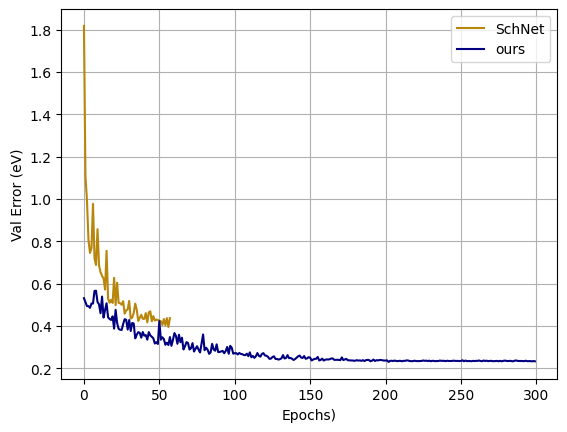

In [ ]:
import ast 
import pandas as pd

with open('/drive/My Drive/best-arch-log.txt', 'r') as file:
    content = file.read()

schnet_logs = pd.read_csv('/drive/My Drive/lightning_logs_version_4.csv')
schnet_val_errors = schnet_logs['Value'].to_list()

content = ast.literal_eval(content)
best_test_error = content[0]
val_errors = content[1]
losses = content[2]
epochs = len(val_errors)

plt.figure()
plt.plot(range(len(schnet_val_errors)), schnet_val_errors, label='SchNet', color='#B8860B')
plt.plot(range(epochs), val_errors, label='ours', color='navy')
plt.xlabel('Epochs)')
plt.ylabel('Val Error (eV)')
plt.grid(True)
plt.legend()  
plt.savefig(f'/drive/My Drive/val-plot.png', dpi=500)
plt.show()

# Controller Architecture 

Here we define the controller architecture. For our experiments we use a transformer layer, but depending on the case it can also be a simple 2-layer MLP in some cases. 

In [ ]:
import torch.nn as nn

def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    """
    State Embeddings
    """
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m

def get_padding_masks(slen, lengths):
    """
    Generate hidden states mask
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]
    assert mask.size() == (bs, slen)
    return mask


def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    """makes an MLP with no top layer activation"""
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))

class TransformerModel(nn.Module):

    def __init__(self, params, transformer_layer, linear_layer):
        """
        Controller
        """
        super().__init__()
        self.embeddings = Embedding(params.n_actions, params.emb_dim, padding_idx=params.pad_index)
        self.linear = linear_layer
        self.transformer_layer = transformer_layer

    def forward(self, x, lengths):
        """
        Inputs:
            `x` LongTensor(bs, slen), containing indices
            `lengths` LongTensor(bs), containing the length of each seq
        """
        
        # check inputs
        bs, slen = x.size()
        assert lengths.size(0) == bs
        assert lengths.max().item() <= slen

        # generate masks
        mask = get_padding_masks(slen, lengths)

        # embeddings
        tensor = self.embeddings(x)
        tensor *= mask.unsqueeze(-1).to(tensor.dtype)
        
        # transformer layer  
        tensor = self.transformer_layer(tensor)
        tensor = self.linear(tensor)
        
        return tensor

# State Space

Define the vocabulary for layers, activations, pooling, as well as the corresponding torch.nn modules they map to. 

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def convert_list_to_dict(lst):
    result_dict = {}
    for i in range(len(lst)):
        result_dict[lst[i]] = i
    return result_dict

def get_non_idxs(action_space):
  non_idxs = []
  for key, value in params.items():
    if key != 'n_actions' and key != 'emb_dim':
      if key not in action_space:
          non_idxs.append(value)
  return non_idxs

lr_space = ['0.005', '0.007']
batch_size_space = ['16', '32']
dims_space = ['64', '128']

gnn_layers_space = ['cgconv', 'graphconv', 'gatconv', 'gcnconv']
aggr_space = ['add', 'mean', 'max']
normalization_space = ['batch_norm', 'graph_size_norm', 'message_norm', 'layer_norm']
linear_layers_space = ['linear']
activation_space = ['relu', 'sigmoid', 'silu', 'tanh', 'leakyrelu']
pooling_space = ['global_add', 'global_mean', 'global_max']
skip_space = ['skip1', 'skip2', 'skip3']
block_space = ['concat', 'sum']

total_space = lr_space + batch_size_space + dims_space + gnn_layers_space + aggr_space + normalization_space + \
              linear_layers_space + activation_space + pooling_space + skip_space + block_space + [str(",")] #pad
space_size = len(total_space)
pad_idx = space_size - 1

params_dict = convert_list_to_dict(total_space)
params = AttrDict({"n_actions":space_size} | params_dict | {"pad_index":pad_idx} | {"emb_dim":100})

non_lr_idxs = get_non_idxs(lr_space)
non_batch_size_idxs = get_non_idxs(batch_size_space)
non_dims_idxs = get_non_idxs(dims_space)
non_gnn_layers_idxs = get_non_idxs(gnn_layers_space)
non_aggr_idxs = get_non_idxs(aggr_space)
non_normalization_idxs = get_non_idxs(normalization_space)
non_linear_layers_idxs = get_non_idxs(linear_layers_space)
non_activation_idxs = get_non_idxs(activation_space)
non_pooling_idxs = get_non_idxs(pooling_space)
non_skip_idxs = get_non_idxs(skip_space)
non_block_idxs = get_non_idxs(block_space)

import torch_geometric
architecture_dict = AttrDict({
    str(list(params.keys()).index('linear') - 1) : nn.Linear,
    str(list(params.keys()).index('graphconv') - 1): torch_geometric.nn.GraphConv,
    str(list(params.keys()).index('gatconv') - 1): torch_geometric.nn.GATConv,
    str(list(params.keys()).index('cgconv') - 1): torch_geometric.nn.CGConv,
    str(list(params.keys()).index('gcnconv') - 1): torch_geometric.nn.GCNConv,
    #str(list(params.keys()).index('gpsconv') - 1): torch_geometric.nn.GPSConv,
    str(list(params.keys()).index('batch_norm') - 1): torch_geometric.nn.BatchNorm,
    str(list(params.keys()).index('graph_size_norm') - 1): torch_geometric.nn.GraphSizeNorm,
    str(list(params.keys()).index('message_norm') - 1): torch_geometric.nn.MessageNorm,
    str(list(params.keys()).index('layer_norm') - 1): torch_geometric.nn.LayerNorm,
    str(list(params.keys()).index('relu') - 1): torch.nn.ReLU,
    str(list(params.keys()).index('tanh') - 1): torch.nn.Tanh,
    str(list(params.keys()).index('sigmoid') - 1): torch.nn.Sigmoid,
    str(list(params.keys()).index('leakyrelu') - 1): torch.nn.LeakyReLU,
    str(list(params.keys()).index('silu') - 1): torch.nn.SiLU,
    str(list(params.keys()).index('global_add') - 1): torch_geometric.nn.global_add_pool,
    str(list(params.keys()).index('global_max') - 1): torch_geometric.nn.global_max_pool,
    str(list(params.keys()).index('global_mean') - 1): torch_geometric.nn.global_mean_pool,
})

del params[',']
params

{'n_actions': 32,
 '0.005': 0,
 '0.007': 1,
 '16': 2,
 '32': 3,
 '64': 4,
 '128': 5,
 'cgconv': 6,
 'graphconv': 7,
 'gatconv': 8,
 'gcnconv': 9,
 'add': 10,
 'mean': 11,
 'max': 12,
 'batch_norm': 13,
 'graph_size_norm': 14,
 'message_norm': 15,
 'layer_norm': 16,
 'linear': 17,
 'relu': 18,
 'sigmoid': 19,
 'silu': 20,
 'tanh': 21,
 'leakyrelu': 22,
 'global_add': 23,
 'global_mean': 24,
 'global_max': 25,
 'skip1': 26,
 'skip2': 27,
 'skip3': 28,
 'concat': 29,
 'sum': 30,
 'pad_index': 31,
 'emb_dim': 100}

# Helper Functions for Action Space

A lot of this has been implemented after first experiment to try to constraint action space and identify bugs for why so many generated architectures we invalid in the initial trial (main results for presentation). It also contains the constructor and another (more manual) constructor for debugging purposes.

In [ ]:
from torch.nn import ModuleList

class NasGNN(nn.Module):
    def __init__(self, blocks, aggrs):

        """
        Constructor for a NAS-generated GNN
        """
        super(NasGNN, self).__init__()


        self.dim = dim
        self.lin0 = torch.nn.Linear(1, dim)

        self.convs = ModuleList()
        self.acts = ModuleList()
        self.norms = ModuleList()

        max_blks = 3
        for i in range(max_blks):
          conv = blocks[i]
          conv.aggr = aggrs[i]
          norm = blocks[3]
          act = blocks[i+4]
          self.convs.append(conv)
          self.norms.append(norm)
          self.acts.append(act)
        
        self.pooling = blocks[-1]
        #self.skip = skip
        self.lin1 = blocks[-2]

        self.lin2 = torch.nn.Linear(dim, 1)

    def forward(self, data):

        """
        Skeleton for forward pass. 
        """

        x = data.x
        out = F.relu(self.lin0(data.x))

        for i in range(len(self.convs)):
          act = self.acts[i]
          conv = self.convs[i]
          norm = self.norms[i]
          out = act(conv(out, data.edge_index, data.edge_attr))
          out = norm(out)

        if self.pooling == str(list(params.keys()).index('global_add') - 1): out = global_add_pool(out, data.batch)
        elif self.pooling == str(list(params.keys()).index('global_mean') - 1): out = global_mean_pool(out, data.batch)
        else: out = global_max_pool(out, data.batch)

        out = F.relu(self.lin1(out))
        out = self.lin2(out)

        return out.view(-1)

class NasGNN(nn.Module):
    def __init__(self, blocks, blocks2, aggrs, aggrs2, aggr_type):

        """
        Note: NOT the final constructor. This is more of a manual 
        sanity check for 2 block architectures to debug invalid configurations
        """
        super(NasGNN, self).__init__()

        # Constructor for only 2 block architectures
        self.dim = dim
        self.lin0 = torch.nn.Linear(1, dim)
        self.conv1 = blocks[0] 
        self.aggr1 = aggrs[0]
        self.conv1.aggr = aggrs[0]
        self.conv1_act = blocks[4] 
        self.conv2 = blocks[1] 
        self.aggr2 = aggrs[1]
        self.conv2.aggr = aggrs[1]
        self.conv2_act = blocks[5] 
        self.conv3 = blocks[2] 
        self.aggr3 = aggrs[2]
        self.conv3.aggr = aggrs[2]
        self.conv3_act = blocks[6]
        self.norm = blocks[3]
        self.pooling = blocks[-1]
        self.lin1 = blocks[-2]

        self.aggr_type = aggr_type

        ##### Block 2
        self.conv4 = blocks2[0] 
        self.aggr4 = aggrs2[0]
        self.conv4.aggr = aggrs2[0]
        self.conv4_act = blocks2[4] 
        self.conv5 = blocks2[1] 
        self.aggr5 = aggrs2[1]
        self.conv5.aggr = aggrs2[1]
        self.conv5_act = blocks2[5] 
        self.conv6 = blocks2[2] 
        self.aggr6 = aggrs2[2]
        self.conv6.aggr = aggrs2[2]
        self.conv6_act = blocks2[6]
        self.norm2 = blocks2[3]
        self.pooling2 = blocks2[-1]
        self.lin12 = blocks2[-2]

        self.lin2 = torch.nn.Linear(dim, 1) # if sum blocks
        self.lin3 = torch.nn.Linear(dim*2, 1) # if concat 2 blocks


    def forward(self, data):

        """
        Note: Manual too. Not generic for smaller architectures
        """

        #### Block 1
        out1 = F.relu(self.lin0(data.x))

        out1 = self.conv1_act(self.conv1(out1, data.edge_index, data.edge_attr))
        out1 = self.norm(out1)
        out1 = self.conv2_act(self.conv2(out1, data.edge_index, data.edge_attr))
        out1 = self.norm(out1)
        out1 = self.conv3_act(self.conv3(out1, data.edge_index, data.edge_attr))
        out1 = self.norm(out1)

        if self.pooling == str(list(params.keys()).index('global_add') - 1): out1 = global_add_pool(out1, data.batch)
        elif self.pooling == str(list(params.keys()).index('global_mean') - 1): out1 = global_mean_pool(out1, data.batch)
        else: out1 = global_max_pool(out1, data.batch)

        out1 = F.relu(self.lin1(out1))

        #### Block 2
        out2 = F.relu(self.lin0(data.x))

        out2 = self.conv4_act(self.conv4(out2, data.edge_index, data.edge_attr))
        out2 = self.norm2(out2)
        out2 = self.conv5_act(self.conv5(out2, data.edge_index, data.edge_attr))
        out2 = self.norm2(out2)
        out2 = self.conv6_act(self.conv6(out2, data.edge_index, data.edge_attr))
        out2 = self.norm2(out2)

        if self.pooling2 == str(list(params.keys()).index('global_add') - 1): out2 = global_add_pool(out2, data.batch)
        elif self.pooling2 == str(list(params.keys()).index('global_mean') - 1): out2 = global_mean_pool(out2, data.batch)
        else: out2 = global_max_pool(out2, data.batch)

        out2 = F.relu(self.lin12(out2))

        if self.aggr_type == 'sum': 
          out = out1 + out2
          out = self.lin2(out) # add
        else: 
          out = torch.cat((out1, out2), dim=1)
          out = self.lin3(out) # concatenation

        return out.view(-1)


def get_action_space(cur_len, scores):

    """
    Returns valid actions in the action space given current sequence length 
    by masking invalid actions (https://arxiv.org/pdf/2006.14171.pdf).
    In this version of the code I was doing some further tests, but for the 
    actual experiments we only masked the hyperparameters since those are necessary
    to be generated always during the first 3 sequence values. The actions in the 
    actual layer logic were not masked to encourage exploration (which is why a lot 
    of the architectures failed). In this setup we have more control and generates 
    more valid architectures.
    """

    mask = -1e8

    # First actions correspond to hyperparameters
    if cur_len == 0:
      for non_lr_idx in non_lr_idxs:
        scores[:,non_lr_idx] = mask 

    if cur_len == 1:
      for non_batch_size_idx in non_batch_size_idxs:
        scores[:,non_batch_size_idx] = mask

    if cur_len == 2:
      for non_dim_idx in non_dims_idxs:
        scores[:,non_dim_idx] = mask 

    # Intermediate actions correspond to actual architecture 
    # We limit up to a max of 3 GNN layers for computational  
    # cost but certainly this is not a restriction 
    if cur_len >= 3 and cur_len <= 5:
      for non_gnn_layer_idx in non_gnn_layers_idxs:
        scores[:,non_gnn_layer_idx] = mask

    if cur_len >= 6 and cur_len <= 8:
      for non_aggr_idx in non_aggr_idxs:
        scores[:,non_aggr_idx] = mask
    
    if cur_len == 9:
      for non_normalization_idx in non_normalization_idxs:
        scores[:,non_normalization_idx] = mask

    # Activation functions for the up to 3 GNN layers
    if cur_len >= 10 and cur_len <= 12:
      for non_activation_idx in non_activation_idxs:
        scores[:,non_activation_idx] = mask

    # Linear layer at end of architecture since we want energy
    if cur_len == 13:
      for non_linear_layers_idx in non_linear_layers_idxs:
        scores[:,non_linear_layers_idx] = mask
    
    # Pooling
    if cur_len == 14:
      for non_pooling_idx in non_pooling_idxs:
        scores[:,non_pooling_idx] = mask
    
    if cur_len == 15:
      for non_block_idx in non_block_idxs:
        scores[:,non_block_idx] = mask

    ### Block 2
    if cur_len == 16:
      for non_lr_idx in non_lr_idxs:
        scores[:,non_lr_idx] = mask 

    if cur_len == 17:
      for non_batch_size_idx in non_batch_size_idxs:
        scores[:,non_batch_size_idx] = mask

    if cur_len == 18:
      for non_dim_idx in non_dims_idxs:
        scores[:,non_dim_idx] = mask 

    if cur_len >= 19 and cur_len <= 21:
      for non_gnn_layer_idx in non_gnn_layers_idxs:
        scores[:,non_gnn_layer_idx] = mask

    if cur_len >= 22 and cur_len <= 23:
      for non_aggr_idx in non_aggr_idxs:
        scores[:,non_aggr_idx] = mask
    
    if cur_len == 24:
      for non_normalization_idx in non_normalization_idxs:
        scores[:,non_normalization_idx] = mask

    if cur_len >= 25 and cur_len <= 27:
      for non_activation_idx in non_activation_idxs:
        scores[:,non_activation_idx] = mask

    if cur_len == 28:
      for non_linear_layers_idx in non_linear_layers_idxs:
        scores[:,non_linear_layers_idx] = mask
    
    if cur_len == 29:
      for non_pooling_idx in non_pooling_idxs:
        scores[:,non_pooling_idx] = mask

    return scores

def get_model(generated, device):

    """
    Get torch.nn.Module object from generated sequence.
    Note to self: this is ugly ugly code. Make more elegant eventually.
    """

    original_generated = generated.copy()
    generated = generated[:15]

    d = 1
    dim = int(list(params.keys())[list(params.values()).index(int(generated[2]))])
    lyrs = generated[3:6]
    aggrs = generated[6:9]
    aggrs = [next(key for key, value in params.items() if str(value) == item) if item.isdigit() and int(item) in params.values() else item for item in aggrs]
    norm = generated[9:10]
    acts = generated[10:13]
    pooling = generated[-1]
    #skip = generated[-1]
    generated_list = lyrs + norm + acts

    blocks1 = []
    for component in generated_list:
        if component in architecture_dict:
            block_type = architecture_dict[component]
            if block_type == Linear:
                block = block_type(in_features=dim, out_features=dim)  
            elif block_type == CGConv:
                block = block_type(dim, d) # aggr later inside init       
            elif block_type == GraphConv or block_type == GATConv or block_type == GCNConv:
                block = block_type(dim, dim) 
            elif block_type == BatchNorm or block_type == LayerNorm:
                block = block_type(dim) 
            elif block_type == GPSConv:
                nn = Sequential(
                    Linear(dim, dim),
                    ReLU(),
                    Linear(dim, dim),
                )
                block = GPSConv(dim, GINEConv(nn), heads=4, attn_dropout=0.5)
            else:
                block = block_type()
            blocks1.append(block)
        else:
            raise ValueError(f"Component '{component}' not found in architecture dictionary.")

    aggr_type = original_generated[15]
    if aggr_type == '29': aggr_type = 'concat'
    else: aggr_type = 'sum'
    generated2 = original_generated[16:]

    d = 1
    dim2 = int(list(params.keys())[list(params.values()).index(int(generated2[2]))])
    lyrs2 = generated2[3:6]
    aggrs2 = generated2[6:9]
    aggrs2 = [next(key for key, value in params.items() if str(value) == item) if item.isdigit() and int(item) in params.values() else item for item in aggrs2]
    norm2 = generated2[9:10]
    acts2 = generated2[10:13]
    pooling2 = generated2[-1]
    generated_list_2 = lyrs2 + norm2 + acts2

    blocks2 = []
    for component in generated_list_2:
        if component in architecture_dict:
            block_type = architecture_dict[component]
            if block_type == Linear:
                block = block_type(in_features=dim, out_features=dim)  
            elif block_type == CGConv:
                block = block_type(dim, d) # aggr later inside init       
            elif block_type == GraphConv or block_type == GATConv or block_type == GCNConv:
                block = block_type(dim, dim) 
            elif block_type == BatchNorm or block_type == LayerNorm:
                block = block_type(dim) 
            elif block_type == GPSConv:
                nn = Sequential(
                    Linear(dim, dim),
                    ReLU(),
                    Linear(dim, dim),
                )
                block = GPSConv(dim, GINEConv(nn), heads=4, attn_dropout=0.5)
            else:
                block = block_type()
            blocks2.append(block)
        else:
            raise ValueError(f"Component '{component}' not found in architecture dictionary.")
    
    model = NasGNN(blocks1 + [pooling], blocks2 + [pooling2], aggrs, aggrs2, aggr_type).to(device)

    return model

# Main Code

Update: I have removed the end token to test with sequences of equal length and try to identify potential bug sources that may be causing the Controller to generate so many invalid architectures. 

In [ ]:
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logZ = torch.zeros((1,)).to(device)

n_hid = 256

# transformer params
n_heads = 4
n_layers = 2

mlp = make_mlp([params.emb_dim] + [n_hid] * n_layers + [params.n_actions]).to(device)
d_model = mlp[0].in_features
encoder_layer = nn.TransformerEncoderLayer(d_model=100, nhead=4).to(device)
transformer_layer = nn.TransformerEncoder(encoder_layer, num_layers=4).to(device)
model = TransformerModel(params, transformer_layer, mlp).to(device)

########## Load Checkpoint here #############
#it = 65
#model = model.load_state_dict(torch.load(f'/drive/My Drive//controller-it{it}.pth'))

P_B = 1 # DAG & autoregressive sequence generation => tree

optim = torch.optim.Adam([ {'params':model.parameters(), 'lr':0.001}, {'params':[logZ], 'lr':0.01} ])
logZ.requires_grad_()

losses_TB = []
zs_TB = []
rewards_TB = []
all_visited_TB = []
l1log_TB = []

batch_size = 10 # training child GNNs is expensive
max_len = 30

n_train_steps = 100
R_evals = []
all_valid_archs_results = [] # this is where we'll eventually gather promising architectures from
total_invalid_archs_per_ep = []

for it in tqdm.trange(n_train_steps): 

    Z = logZ.exp()

    flag = True
    if flag:
        ll_diff = torch.zeros((batch_size,)).to(device)
        ll_diff += logZ
    else:
        in_probs = torch.ones(batch_size, dtype=torch.float, requires_grad=True).to(device)

    # Generate a tensor of expected sequence length
    generated = torch.LongTensor(batch_size, max_len)
    generated.fill_(-1)
    gen_len = torch.LongTensor(batch_size,).fill_(0) 
    unfinished_sents = gen_len.clone().fill_(1) 

    cur_len = 0
    while cur_len < max_len:
        
        state = generated[:,:cur_len] + 0
        tensor = model(state.to(device), lengths=gen_len.to(device))
        scores = tensor.sum(dim=1)
        scores = get_action_space(cur_len, scores)
        scores = scores.log_softmax(1)
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        assert torch.allclose(torch.sum(probs,1).to(device), torch.ones([batch_size]).to(device)) # sanity check to ensure normalization of probabilities
        next_action = torch.multinomial(probs, 1).squeeze(1)

        # update generations
        generated[:,cur_len] = next_action.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents) 
        cur_len += 1

        # Trajectory Balance loss
        if flag:
            ll_diff += scores.gather(1, next_action.unsqueeze(-1)).squeeze(1)
        else:
            sample_in_probs = probs.gather(1, next_action.unsqueeze(-1)).squeeze(1)
            sample_in_probs[unfinished_sents == 0] = 1.
            in_probs = in_probs * sample_in_probs
      
        # stop when all architectures have a final dense layer (maps to predicted energies)
        if unfinished_sents.max() == 0:
            break

    generated_list = generated.tolist()

    invalid_archs_ctr = 0
    R = tuple()
    for generated in generated_list:
      try:
        generated = [str(item) for item in generated]
        print("generated: ", generated)
        lr = float(list(params.keys())[list(params.values()).index(int(generated[0]))])
        batch_size_gnn = int(list(params.keys())[list(params.values()).index(int(generated[1]))])

        epochs = 100
        #epochs = 2
        gnn_model = get_model(generated, device)
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                              factor=0.7, patience=5,
                                                              min_lr=0.00001)
        best_val_error, losses = train_architecture(gnn_model, batch_size_gnn, epochs)
        reward = torch.Tensor([1.0 - best_val_error])
        R += (reward,) 
        arch_results = (generated, best_val_error, losses, reward)
        all_valid_archs_results.append(arch_results)

      except: # invalid architecture
        #print("Invalid: ", generated)
        invalid_archs_ctr += 1
        reward = torch.Tensor([0.0])
        R += (reward,) 

    path = '/drive/My Drive/all_valid_archs_results.txt'  
    with open(path, 'w') as file:
        file.write(str(all_valid_archs_results) + '\n')
        file.close()
    
    print(f"{invalid_archs_ctr} total invalid architectures found in iter {it}")
    total_invalid_archs_per_ep.append(invalid_archs_ctr)

    R = torch.cat(R).to(device)
    assert R.is_contiguous() 
    # sanity check to ensure we get rewards for all child GNNs
    assert R.size()[0] == batch_size

    optim.zero_grad()
    if flag :
        ll_diff -= R
        loss = (ll_diff**2).sum()/batch_size
    else :
        loss = ((Z*in_probs / R).log()**2).sum()/batch_size

    loss.backward()
    optim.step()

    losses_TB.append(loss.item())
    zs_TB.append(Z.item())
    rewards_TB.append(R.mean().cpu())
    all_visited_TB.extend(generated)
    R_evals.append(R.cpu())

    torch.save(model.state_dict(), f'/drive/My Drive/controller-it{it}.pth')

    print('\nloss =', np.array(losses_TB[-100:]).mean(), 'Z =', Z.item(), "R =", np.array(rewards_TB[-100:]).mean() )
    if losses_TB[it] < 1.0: 
      break

  0%|          | 0/100 [00:00<?, ?it/s]

generated:  ['0', '2', '5', '9', '6', '8', '10', '12', '12', '14', '20', '18', '22', '17', '25', '29', '0', '2', '5', '8', '8', '6', '12', '12', '13', '21', '19', '21', '17', '25']
generated:  ['1', '2', '5', '9', '6', '7', '12', '12', '12', '13', '18', '19', '21', '17', '24', '30', '0', '3', '5', '8', '7', '8', '12', '12', '15', '18', '22', '21', '17', '25']
generated:  ['1', '3', '5', '6', '7', '8', '12', '10', '10', '13', '18', '18', '21', '17', '24', '29', '0', '3', '5', '6', '6', '8', '10', '10', '14', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '9', '6', '7', '10', '10', '12', '14', '21', '22', '22', '17', '24', '29', '0', '3', '5', '7', '6', '8', '12', '12', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7464180,Val MAE: 0.5503074
Epoch: 002, LR: 0.007000, Loss: 0.6690223,Val MAE: 0.7076923
Epoch: 003, LR: 0.007000, Loss: 0.6926462,Val MAE: 0.5313276
Epoch: 004, LR: 0.007000, Loss: 0.6573904,Val MAE: 0.5096224
Epoch: 005, LR: 0.007000, Loss: 

  1%|          | 1/100 [05:35<9:13:11, 335.27s/it]


loss = 702.872802734375 Z = 1.0 R = 0.049971607
generated:  ['0', '2', '5', '7', '8', '8', '12', '12', '12', '13', '21', '21', '21', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '13', '21', '21', '21', '17', '25']
generated:  ['1', '3', '4', '9', '8', '9', '10', '10', '12', '14', '21', '21', '21', '17', '25', '29', '0', '2', '5', '8', '9', '8', '12', '12', '13', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7471291,Val MAE: 0.5903691
Epoch: 002, LR: 0.007000, Loss: 0.7276653,Val MAE: 0.6594608
Epoch: 003, LR: 0.007000, Loss: 0.7417425,Val MAE: 0.6949678
Epoch: 004, LR: 0.007000, Loss: 0.7226649,Val MAE: 0.5222729
Epoch: 005, LR: 0.007000, Loss: 0.7235466,Val MAE: 0.5375240
Epoch: 006, LR: 0.007000, Loss: 0.7216106,Val MAE: 0.6102721
Epoch: 007, LR: 0.007000, Loss: 0.7359854,Val MAE: 0.5453553
Epoch: 008, LR: 0.007000, Loss: 0.7281430,Val MAE: 0.5221851
Epoch: 009, LR: 0.007000, Loss: 0.7267416,Val MAE: 0.5209162
Epoch: 010, LR: 0.007000, Loss: 0.718856

  2%|▏         | 2/100 [13:17<11:09:15, 409.75s/it]


loss = 424.04747772216797 Z = 1.0100501775741577 R = 0.049033027
generated:  ['1', '2', '5', '6', '9', '9', '12', '12', '10', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '3', '5', '8', '8', '9', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '5', '9', '9', '8', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '5', '9', '9', '9', '12', '12', '10', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '3', '5', '9', '9', '9', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '3', '4', '

  3%|▎         | 3/100 [13:17<6:00:33, 223.03s/it] 


loss = 300.5597407023112 Z = 1.0193164348602295 R = 0.032688685
generated:  ['0', '3', '5', '9', '7', '9', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '9', '9', '9', '12', '12', '12', '15', '22', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '8', '8', '9', '12', '12', '12', '15', '21', '21', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '5', '9', '8', '9', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '5', '7', '8', '9', '12', '12', '12', '15', '22', '21', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '5', '9

  4%|▍         | 4/100 [13:18<3:36:29, 135.31s/it]


loss = 240.465256690979 Z = 1.0278785228729248 R = 0.024516514
generated:  ['0', '2', '5', '9', '7', '9', '12', '10', '12', '15', '22', '21', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '22', '21', '22', '17', '25']
generated:  ['1', '2', '5', '9', '9', '9', '12', '12', '12', '15', '21', '22', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '22', '22', '21', '17', '25']
generated:  ['0', '3', '4', '9', '9', '9', '12', '12', '10', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '21', '21', '22', '17', '25']
generated:  ['1', '2', '5', '9', '8', '9', '12', '12', '12', '15', '21', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '10', '15', '22', '22', '21', '17', '25']
generated:  ['1', '2', '5', '7', '9', '9', '12', '10', '10', '15', '21', '21', '21', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '6'

  5%|▌         | 5/100 [13:19<2:17:30, 86.84s/it] 


loss = 212.67311630249023 Z = 1.0361911058425903 R = 0.01961321
generated:  ['1', '2', '5', '8', '9', '9', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '9', '9', '9', '12', '10', '10', '15', '21', '21', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '9', '9', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '9', '9', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '9', '9', '9', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8

  6%|▌         | 6/100 [13:20<1:30:07, 57.52s/it]


loss = 188.7924836476644 Z = 1.0446820259094238 R = 0.016344342
generated:  ['0', '3', '5', '8', '9', '6', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '8', '9', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '9', '9', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '9', '9', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '9', '9', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '9

  7%|▋         | 7/100 [13:21<1:00:21, 38.94s/it]


loss = 173.02521351405554 Z = 1.0531786680221558 R = 0.014009437
generated:  ['0', '2', '5', '8', '8', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '9', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '9', '9', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '9', '9', '9', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '9', '9', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '

  8%|▊         | 8/100 [13:21<41:00, 26.74s/it]  


loss = 157.52495002746582 Z = 1.061743140220642 R = 0.012258257
generated:  ['1', '2', '5', '6', '9', '9', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '8', '9', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '9', '9', '9', '12', '11', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '8', '8', '9', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8', '9', '8', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '9

  9%|▉         | 9/100 [13:22<28:10, 18.58s/it]


loss = 146.870544857449 Z = 1.0702179670333862 R = 0.010896228
generated:  ['0', '2', '5', '8', '9', '9', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '9', '9', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '9', '9', '9', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '9', '9', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '9', '9', '9', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8'

 10%|█         | 10/100 [13:22<19:33, 13.04s/it]


loss = 136.65962562561035 Z = 1.0787296295166016 R = 0.009806605
generated:  ['1', '3', '5', '9', '9', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '9', '9', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '8', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '8', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '9', '9', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '9', '9', '9', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '

 11%|█         | 11/100 [13:24<14:02,  9.46s/it]


loss = 131.33086013793945 Z = 1.087194561958313 R = 0.008915096
generated:  ['0', '2', '5', '8', '7', '7', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '9', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '8', '9', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '9', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '8', '9', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '8', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '9', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8

 12%|█▏        | 12/100 [13:25<10:13,  6.97s/it]


loss = 128.53463713328043 Z = 1.0958251953125 R = 0.008172171
generated:  ['1', '2', '5', '9', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '9', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '9', '9', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '9', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '9', '9', '9', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '9', '9', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '7', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '9', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '7',

 13%|█▎        | 13/100 [13:26<07:38,  5.27s/it]


loss = 126.20251846313477 Z = 1.1047415733337402 R = 0.0075435424
generated:  ['0', '2', '5', '8', '7', '9', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '9', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '7', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '9', '7', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '9', '8', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', 

 14%|█▍        | 14/100 [13:28<05:58,  4.17s/it]


loss = 121.78775760105678 Z = 1.113916277885437 R = 0.0070047183
generated:  ['1', '2', '4', '9', '7', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '7', '9', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '8', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '

 15%|█▌        | 15/100 [13:29<04:44,  3.35s/it]


loss = 118.55707015991212 Z = 1.1231739521026611 R = 0.006537737
generated:  ['1', '2', '5', '8', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '9', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '8', '8', '9', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '8', '8', '8', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '9', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '

 16%|█▌        | 16/100 [13:31<03:55,  2.80s/it]


loss = 115.01789236068726 Z = 1.1325688362121582 R = 0.0061291284
generated:  ['1', '2', '5', '8', '8', '9', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '9', '8', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', 

 17%|█▋        | 17/100 [13:33<03:24,  2.47s/it]


loss = 112.14925474279067 Z = 1.1420387029647827 R = 0.0057685915
generated:  ['1', '2', '5', '7', '8', '8', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '7', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', 

 18%|█▊        | 18/100 [13:34<02:55,  2.14s/it]


loss = 108.11770227220323 Z = 1.1516034603118896 R = 0.005448114
generated:  ['0', '2', '5', '9', '8', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '8', '7', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '7', '9', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '

 19%|█▉        | 19/100 [13:35<02:33,  1.90s/it]


loss = 104.9752416108784 Z = 1.1610994338989258 R = 0.005161371
generated:  ['0', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '9', '8', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '7', '8', '8', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8

 20%|██        | 20/100 [13:37<02:18,  1.73s/it]


loss = 101.5724063873291 Z = 1.1706039905548096 R = 0.0049033025
generated:  ['0', '2', '4', '8', '7', '7', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '

 21%|██        | 21/100 [13:38<02:15,  1.72s/it]


loss = 98.21753420148578 Z = 1.1800438165664673 R = 0.004669812
generated:  ['1', '2', '4', '8', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '7', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '7', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8

 22%|██▏       | 22/100 [13:40<02:05,  1.60s/it]


loss = 95.04571229761297 Z = 1.189362645149231 R = 0.004457548
generated:  ['1', '2', '5', '8', '8', '7', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '9', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '8', '9', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8'

 23%|██▎       | 23/100 [13:41<01:56,  1.51s/it]


loss = 92.27962145598039 Z = 1.198576807975769 R = 0.0042637414
generated:  ['0', '3', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '8', '7', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8

 24%|██▍       | 24/100 [13:42<01:52,  1.48s/it]


loss = 89.90860954920451 Z = 1.2077033519744873 R = 0.0040860856
generated:  ['1', '2', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '

 25%|██▌       | 25/100 [13:44<01:55,  1.54s/it]


loss = 87.46158660888672 Z = 1.2167807817459106 R = 0.003922642
generated:  ['0', '2', '5', '7', '7', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '8', '7', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8

 26%|██▌       | 26/100 [13:46<01:54,  1.55s/it]


loss = 85.90849186823918 Z = 1.2257614135742188 R = 0.0037717712
generated:  ['0', '2', '4', '8', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '7', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '

 27%|██▋       | 27/100 [13:47<01:48,  1.48s/it]


loss = 84.34187514693649 Z = 1.2348788976669312 R = 0.003632076
generated:  ['1', '2', '5', '9', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '7', '8', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '5', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '8

 28%|██▊       | 28/100 [13:48<01:43,  1.44s/it]


loss = 83.14599132537842 Z = 1.244085669517517 R = 0.0035023591
generated:  ['1', '2', '4', '7', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '7', '7', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '8', '9', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '8', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8

 29%|██▉       | 29/100 [13:50<01:39,  1.41s/it]


loss = 81.63415658885035 Z = 1.25346040725708 R = 0.003381588
generated:  ['0', '3', '5', '7', '8', '7', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '7', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8', '8', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '9', '7', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8',

 30%|███       | 30/100 [19:12<1:53:59, 97.71s/it]


loss = 80.79902509053548 Z = 1.262912631034851 R = 0.005127085
generated:  ['1', '2', '4', '6', '8', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '7', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '7', '8', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '8', '7', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '7', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8'

 31%|███       | 31/100 [19:13<1:19:05, 68.77s/it]


loss = 79.87904333299205 Z = 1.2725770473480225 R = 0.004961695
generated:  ['1', '2', '4', '8', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '8', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '5', '7', '8', '7', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '7', '7', '8', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8', '7', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '7

 32%|███▏      | 32/100 [19:15<55:00, 48.54s/it]  


loss = 79.05168390274048 Z = 1.2824361324310303 R = 0.004806642
generated:  ['0', '2', '5', '8', '8', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '8', '8', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '7', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '7', '8', '8', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7

 33%|███▎      | 33/100 [19:16<38:26, 34.43s/it]


loss = 78.11452148899888 Z = 1.2924902439117432 R = 0.0046609864
generated:  ['1', '2', '4', '8', '7', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '7', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '6', '8', '7', '12', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '7', '8', '8', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8', '7', '8', '12', '12', '12', '15', '21', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '8', '8', '7', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '

 34%|███▍      | 34/100 [19:18<27:01, 24.57s/it]


loss = 78.32860105177936 Z = 1.3027056455612183 R = 0.0045238985
generated:  ['0', '2', '5', '8', '8', '8', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '8', '8', '8', '10', '12', '10', '15', '22', '21', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '8', '8', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '8', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '7', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '9', '8', '7', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '

 35%|███▌      | 35/100 [24:16<1:55:29, 106.60s/it]


loss = 78.73793803623744 Z = 1.3133403062820435 R = 0.005737243
generated:  ['0', '3', '4', '7', '7', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '8', '7', '8', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '7', '8', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '7', '6', '7', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '8', '7', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '6', '7', '8', '10', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '7

 36%|███▌      | 36/100 [24:17<1:20:00, 75.01s/it] 


loss = 79.06721231672499 Z = 1.3244273662567139 R = 0.0055778753
generated:  ['0', '3', '4', '8', '7', '7', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '8', '8', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '8', '7', '7', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '7', '8', '8', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '7', '8', '10', '12', '12', '15', '22', '21', '22', '17', '25', '29', '0', '2', '4', '7', '7', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '7', '7', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '8', '7', '8', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '

 37%|███▋      | 37/100 [28:03<2:06:19, 120.30s/it]


loss = 79.4453243564915 Z = 1.335890769958496 R = 0.0062580206
generated:  ['1', '2', '4', '7', '8', '8', '10', '10', '10', '15', '21', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '7', '7', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '8', '7', '7', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '8', '7', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '7', '8', '7', '10', '10', '10', '13', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
Epoch: 001, LR: 0.005000, Loss:

 38%|███▊      | 38/100 [33:15<3:03:48, 177.89s/it]


loss = 78.86259811802914 Z = 1.3477400541305542 R = 0.0071838438
generated:  ['1', '3', '4', '8', '7', '7', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '5', '7', '8', '7', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '7', '7', '7', '12', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '12', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '7', '7', '7', '10', '12', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '5', '

 39%|███▉      | 39/100 [33:17<2:07:06, 125.02s/it]


loss = 78.25337434426332 Z = 1.359709620475769 R = 0.0069996426
generated:  ['1', '3', '4', '7', '7', '8', '12', '10', '10', '15', '21', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['0', '3', '4', '7', '7', '7', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '10', '10', '10', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '9', '7', '10', '12', '12', '13', '21', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 34165.7318014,Val MAE: 365.8778990
Epoch: 002, LR: 0.007000, Loss: 275.8844758,Val MAE: 4.4846819
Epoch: 003, LR: 0.007000, Loss: 1.8271751,Val MAE: 2.0079660
Epoch: 004, LR: 0.00

 40%|████      | 40/100 [36:46<2:30:10, 150.18s/it]


loss = 77.89286642074585 Z = 1.3717527389526367 R = 0.007827751
generated:  ['1', '2', '5', '7', '7', '7', '12', '10', '10', '13', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '8', '7', '7', '10', '10', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '10', '10', '12', '13', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '10', '10', '15', '22', '22', '22', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 44507.8190180,Val MAE: 717.5004406
Epoch: 002, LR: 0.007000, Loss: 101.5943691,Val MAE: 81.9037822
Epoch: 003, LR: 0.007000, Loss: 79.8434957,Val MAE: 14.6690653
Epoch: 004, LR: 0.007000, Loss: 16.8476163,Val MAE: 32.4409179
Epoch: 005, LR: 0.007000, Loss: 19.0961415,Val MAE: 6.0301089
Epoch: 006, LR: 0.007000, Loss: 23.1856809,Val MAE: 11.3475788
Epoch: 007

 41%|████      | 41/100 [42:56<3:32:39, 216.27s/it]


loss = 77.47063529782179 Z = 1.3839263916015625 R = 0.009307128
generated:  ['0', '2', '4', '7', '7', '7', '12', '10', '12', '13', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '10', '15', '22', '22', '22', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 17347.2632950,Val MAE: 1589.2754868
Epoch: 002, LR: 0.005000, Loss: 633.8815507,Val MAE: 2.5619914
Epoch: 003, LR: 0.005000, Loss: 1.5909605,Val MAE: 3.8561071
Epoch: 004, LR: 0.005000, Loss: 1.1413981,Val MAE: 1.5440272
Epoch: 005, LR: 0.005000, Loss: 1.1450647,Val MAE: 2.6420335
Epoch: 006, LR: 0.005000, Loss: 1.2963900,Val MAE: 1.5214818
Epoch: 007, LR: 0.005000, Loss: 228.9881167,Val MAE: 7.5594132
Epoch: 008, LR: 0.005000, Loss: 84.2343015,Val MAE: 3.8639817
Epoch: 009, LR: 0.005000, Loss: 2.4866880,Val MAE: 3.7877859
Epoch: 010, LR: 0.005000, Loss: 2.6168995,Val MAE: 1.0549585
Epoch: 011, LR: 0.005000, Loss: 1.5360086,Val MAE: 1.2419095
Epoch: 012, LR: 0.005000, Loss: 1.4633747,Val MAE: 1.0010988
Epoch: 013

 42%|████▏     | 42/100 [48:40<4:05:57, 254.43s/it]


loss = 77.7415828704834 Z = 1.3962321281433105 R = 0.0099554695
generated:  ['1', '3', '4', '7', '7', '7', '12', '12', '10', '15', '21', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '5', '7', '7', '7', '12', '10', '12', '13', '21', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['0', '2', '4', '6', '7', '7', '10', '12', '12', '15', '22', '22', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '9', '7', '7', '12', '12', '12', '15', '22', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '12', '10', '12', '15', '22', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '10', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7

 43%|████▎     | 43/100 [48:41<2:49:33, 178.48s/it]


loss = 77.96672528289085 Z = 1.4088771343231201 R = 0.009723946
generated:  ['0', '3', '4', '6', '7', '7', '11', '12', '12', '15', '22', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '10', '12', '12', '15', '22', '22', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '22', '21', '17', '25']
generated:  ['1', '2', '5', '8', '7', '7', '12', '12', '12', '13', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '22', '17', '25']
generated:  ['1', '2', '4', '8', '6', '7', '12', '10', '12', '15', '21', '21', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '22', '21', '17', '25']
generated:  ['0', '2', '5', '7', '7', '7', '12', '12', '12', '13', '21', '22', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '22', '22', '22', '17', '25']
generated:  ['1', '3', '4', '7

 44%|████▍     | 44/100 [53:09<3:11:37, 205.31s/it]


loss = 78.71091643246737 Z = 1.421838402748108 R = 0.0104382215
generated:  ['1', '3', '5', '7', '7', '7', '12', '12', '12', '13', '21', '21', '22', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7', '7', '7', '12', '12', '12', '15', '22', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '3', '4', '8', '7', '7', '12', '12', '10', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7

 45%|████▌     | 45/100 [53:10<2:12:06, 144.11s/it]


loss = 77.95022082858615 Z = 1.4352539777755737 R = 0.010206261
generated:  ['1', '2', '5', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7', '8', '7', '10', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '5', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '5', '8', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '9

 46%|████▌     | 46/100 [53:12<1:31:08, 101.26s/it]


loss = 77.04643713909647 Z = 1.4485538005828857 R = 0.009984386
generated:  ['0', '2', '4', '7', '8', '7', '12', '12', '12', '13', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7386534,Val MAE: 0.9201353
Epoch: 002, LR: 0.005000, Loss: 0.6702392,Val MAE: 1.2093817
Epoch: 003, LR: 0.005000, Loss: 0.6546288,Val MAE: 1.1226714
Epoch: 004, LR: 0.005000, Loss: 0.6619585,Val MAE: 0.9783685
Epoch: 005, LR: 0.005000, Loss: 0.6540912,Val MAE: 0.7354309
Epoch: 006, LR: 0.005000, Loss: 0.6530514,Val MAE: 0.5530081
Epoch: 007, LR: 0.005000, Loss: 0.6491235,Val MAE: 0.5518450
Epoch: 008, LR: 0.005000, Loss: 0.6511631,Val MAE: 0.5764599
Epoch: 009, LR: 0.005000, Loss: 0.6624592,Val MAE: 1.3341886
Epoch: 010, LR: 0.005000, Loss: 0.6580860,Val MAE: 0.7817809
Epoch: 011, LR: 0.005000, Loss: 0.6574583,Val MAE: 0.5299516
Epoch: 012, LR: 0.005000, Loss: 0.6446891,Val MAE: 0.7601856
Epoch: 013, LR: 0.0050

 47%|████▋     | 47/100 [59:15<2:38:55, 179.91s/it]


loss = 76.07089079187271 Z = 1.4616308212280273 R = 0.011847148
generated:  ['1', '3', '5', '6', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '3', '4', '7', '9', '8', '12', '12', '12', '13', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7565529,Val MAE: 0.7853186
Epoch: 002, LR: 0.007000, Loss: 0.7135004,Val MAE: 0.7578472
Epoch: 003, LR: 0.007000, Loss: 0.7278244,Val MAE: 0.5180541
Epoch: 004, LR: 0.007000, Loss: 0.7092530,Val MAE: 0.7011900
Epoch: 005, LR: 0.007000, Loss: 0.7173920,Val MAE: 0.5468257
Epoch: 006, LR: 0.007000, Loss: 0.7089620,Val MAE: 0.5303198
Epoch: 007, LR: 0.007000, Loss: 0.7157153,Val MAE: 0.6505782
Epoch: 008, LR: 0.007000, Loss: 0.7162731,Val MAE: 0.5830662
Epoch: 009, LR: 0.007000, Loss: 0.7142268,Val MAE: 0.6025976
Epoch: 010, LR: 0.004900

 48%|████▊     | 48/100 [1:10:48<4:49:16, 333.78s/it]


loss = 75.67306113243103 Z = 1.474444031715393 R = 0.0137385735
generated:  ['0', '2', '4', '6', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '3', '5', '6', '8', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '7

 49%|████▉     | 49/100 [1:14:00<4:07:40, 291.39s/it]


loss = 74.90960942482462 Z = 1.4873416423797607 R = 0.014436722
generated:  ['1', '2', '4', '7', '7', '7', '12', '12', '12', '13', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7473998,Val MAE: 0.9096982
Epoch: 002, LR: 0.007000, Loss: 0.6595836,Val MAE: 1.2488642
Epoch: 003, LR: 0.007000, Loss: 0.6708055,Val MAE: 1.1202329
Epoch: 004, LR: 0.007000, Loss: 0.6612678,Val MAE: 1.5389764
Epoch: 005, LR: 0.007000, Loss: 0.6532031,Val MAE: 1.0963322
Epoch: 006, LR: 0.007000, Loss: 0.6607716,Val MAE: 1.6551966
Epoch: 007, LR: 0.007000, Loss: 0.6582167,Val MAE: 1.9825444
Epoch: 008, LR: 0.004900, Loss: 0.6552916,Val MAE: 0.5202515
Epoch: 009, LR: 0.004900, Loss: 0.6518029,Val MAE: 0.6108459
Epoch: 010, LR: 0.004900, Loss: 0.6512154,Val MAE: 0.5437639
Epoch: 011, LR: 0.004900, Loss: 0.6565539,Val MAE: 0.5570156
Epoch: 012, LR: 0.004900, Loss: 0.6565118,Val MAE: 0.8870375
Epoch: 013, LR: 0.0049

 50%|█████     | 50/100 [1:20:54<4:33:28, 328.18s/it]


loss = 74.06407974243164 Z = 1.5000430345535278 R = 0.016104016
generated:  ['0', '3', '4', '7', '7', '7', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '9', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '6', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '8', '6', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '8', '7', '8', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '5', '8

 51%|█████     | 51/100 [1:20:56<3:07:54, 230.10s/it]


loss = 73.81085234997319 Z = 1.5125617980957031 R = 0.015788252
generated:  ['1', '2', '4', '7', '7', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '3', '5', '7', '9', '7', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '3', '4', '7', '7', '9', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '3', '4', '8', '7', '8', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '8', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7', '7', '8', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '5', '8

 52%|█████▏    | 52/100 [1:20:57<2:09:10, 161.46s/it]


loss = 73.32342169835017 Z = 1.5252916812896729 R = 0.015484631
generated:  ['0', '2', '4', '7', '7', '8', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '8', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7', '6', '8', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '9', '7', '7', '12', '12', '10', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '7', '7', '9', '11', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '3', '4', '7', '7', '9', '12', '10', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['1', '3', '4', '8

 53%|█████▎    | 53/100 [1:35:39<4:55:52, 377.71s/it]


loss = 73.31049598837798 Z = 1.5381258726119995 R = 0.018936826
generated:  ['0', '2', '5', '9', '7', '6', '12', '12', '12', '15', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
generated:  ['0', '2', '4', '7', '7', '8', '12', '10', '12', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '7', '8', '8', '12', '12', '15', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7694780,Val MAE: 0.5444890
Epoch: 002, LR: 0.005000, Loss: 0.7215634,Val MAE: 0.5620319
Epoch: 003, LR: 0.005000, Loss: 0.7016163,Val MAE: 0.5268908
Epoch: 004, LR: 0.005000, Loss: 0.6872866,Val MAE: 0.5574185
Epoch: 005, LR: 0.005000, Loss: 0.6743453,Val MAE: 0.5598152
Epoch: 006, LR: 0.005000, Loss: 0.6728627,Val MAE: 0.5631638
Epoch: 007, LR: 0.005000, Loss: 0.6589483,Val MAE: 0.5852467
Epoch: 008, LR: 0.005000, Loss: 0.6490833,Val MAE: 0.5220709
Epoch: 009, LR: 0.005000, Loss: 0.6470203,Val MAE: 0.7024995
Epoch: 010, LR: 0.005000

 54%|█████▍    | 54/100 [1:56:15<8:06:57, 635.16s/it]


loss = 74.43611717224121 Z = 1.5513510704040527 R = 0.022283336
generated:  ['0', '2', '4', '6', '8', '6', '11', '12', '12', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '7', '7', '12', '12', '15', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7643924,Val MAE: 0.5482902
Epoch: 002, LR: 0.005000, Loss: 0.7196868,Val MAE: 0.5440152
Epoch: 003, LR: 0.005000, Loss: 0.6843698,Val MAE: 0.5270807
Epoch: 004, LR: 0.005000, Loss: 0.6709350,Val MAE: 0.7000748
Epoch: 005, LR: 0.005000, Loss: 0.6638898,Val MAE: 0.5482258
Epoch: 006, LR: 0.005000, Loss: 0.6586297,Val MAE: 0.5856449
Epoch: 007, LR: 0.005000, Loss: 0.6797787,Val MAE: 0.5131462
Epoch: 008, LR: 0.005000, Loss: 0.6709930,Val MAE: 0.5161436
Epoch: 009, LR: 0.005000, Loss: 0.6637600,Val MAE: 0.6183336
Epoch: 010, LR: 0.005000, Loss: 0.6631199,Val MAE: 0.5885127
Epoch: 011, LR: 0.005000, Loss: 0.6475359,Val MAE: 0.5131545
Epoch: 012, LR: 0.005000, Loss: 0.6524337,Val MAE: 0.5082561
Epoch: 013, LR: 0.0050

 55%|█████▌    | 55/100 [2:23:06<11:35:56, 927.93s/it]


loss = 75.31760413429954 Z = 1.5653209686279297 R = 0.027294291
generated:  ['0', '2', '4', '8', '7', '7', '12', '11', '12', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7747621,Val MAE: 0.5471240
Epoch: 002, LR: 0.005000, Loss: 0.7165309,Val MAE: 0.5231495
Epoch: 003, LR: 0.005000, Loss: 0.7203287,Val MAE: 0.5637873
Epoch: 004, LR: 0.005000, Loss: 0.7133318,Val MAE: 0.5971702
Epoch: 005, LR: 0.005000, Loss: 0.7187317,Val MAE: 0.5334297
Epoch: 006, LR: 0.005000, Loss: 0.7144578,Val MAE: 0.5170961
Epoch: 007, LR: 0.005000, Loss: 0.7216234,Val MAE: 0.5464511
Epoch: 008, LR: 0.005000, Loss: 0.7194780,Val MAE: 0.5479634
Epoch: 009, LR: 0.005000, Loss: 0.7136183,Val MAE: 0.5618043
Epoch: 010, LR: 0.005000, Loss: 0.7136323,Val MAE: 0.5335198
Epoch: 011, LR: 0.005000, Loss: 0.7135143,Val MAE: 0.5629570
Epoch: 012, LR: 0.005000, Loss: 0.7130121,Val MAE: 0.5485866
Epoch: 013, LR: 0.0035

 56%|█████▌    | 56/100 [2:51:24<14:09:55, 1158.99s/it]


loss = 76.3641152381897 Z = 1.5799790620803833 R = 0.0314365
generated:  ['0', '2', '4', '8', '7', '8', '10', '12', '12', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7635811,Val MAE: 0.5231405
Epoch: 002, LR: 0.005000, Loss: 0.7167503,Val MAE: 0.5229321
Epoch: 003, LR: 0.005000, Loss: 0.6907030,Val MAE: 0.6158766
Epoch: 004, LR: 0.005000, Loss: 0.6733566,Val MAE: 0.5365273
Epoch: 005, LR: 0.005000, Loss: 0.6557600,Val MAE: 0.5096618
Epoch: 006, LR: 0.005000, Loss: 0.6509235,Val MAE: 0.6091870
Epoch: 007, LR: 0.005000, Loss: 0.6495712,Val MAE: 0.5301727
Epoch: 008, LR: 0.005000, Loss: 0.6484531,Val MAE: 0.5343004
Epoch: 009, LR: 0.005000, Loss: 0.6476213,Val MAE: 0.5204889
Epoch: 010, LR: 0.005000, Loss: 0.6455217,Val MAE: 0.5112453
Epoch: 011, LR: 0.005000, Loss: 0.6429105,Val MAE: 0.5194799
Epoch: 012, LR: 0.003500, Loss: 0.6468227,Val MAE: 0.5138417
Epoch: 013, LR: 0.003500,

 57%|█████▋    | 57/100 [3:29:54<17:58:03, 1504.26s/it]


loss = 76.6792071827671 Z = 1.5953118801116943 R = 0.03635235
generated:  ['0', '3', '4', '8', '8', '6', '12', '12', '12', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '12', '12', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7561560,Val MAE: 0.5174839
Epoch: 002, LR: 0.005000, Loss: 0.7014176,Val MAE: 0.5967254
Epoch: 003, LR: 0.005000, Loss: 0.6899573,Val MAE: 0.5102383
Epoch: 004, LR: 0.005000, Loss: 0.6858035,Val MAE: 0.5493742
Epoch: 005, LR: 0.005000, Loss: 0.6643505,Val MAE: 0.5414498
Epoch: 006, LR: 0.005000, Loss: 0.6577004,Val MAE: 0.6326260
Epoch: 007, LR: 0.005000, Loss: 0.6567877,Val MAE: 0.5325782
Epoch: 008, LR: 0.005000, Loss: 0.6449156,Val MAE: 0.5460168
Epoch: 009, LR: 0.005000, Loss: 0.6446765,Val MAE: 0.5308497
Epoch: 010, LR: 0.003500, Loss: 0.6385252,Val MAE: 0.5606522
Epoch: 011, LR: 0.003500, Loss: 0.6393916,Val MAE: 0.5483580
Epoch: 012, LR: 0.003500, Loss: 0.6373225,Val MAE: 0.5216474
Epoch: 013, LR: 0.003500

 58%|█████▊    | 58/100 [4:08:52<20:27:56, 1754.21s/it]


loss = 77.45639715523555 Z = 1.6110066175460815 R = 0.04175405
generated:  ['0', '2', '4', '6', '7', '8', '10', '10', '10', '14', '21', '21', '21', '17', '24', '30', '0', '2', '4', '8', '8', '8', '12', '12', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7657165,Val MAE: 0.5424421
Epoch: 002, LR: 0.005000, Loss: 0.7196145,Val MAE: 0.5131622
Epoch: 003, LR: 0.005000, Loss: 0.6986162,Val MAE: 0.5340266
Epoch: 004, LR: 0.005000, Loss: 0.6815393,Val MAE: 0.5173788
Epoch: 005, LR: 0.005000, Loss: 0.6474463,Val MAE: 0.4901983
Epoch: 006, LR: 0.005000, Loss: 0.6484902,Val MAE: 0.5407255
Epoch: 007, LR: 0.005000, Loss: 0.7475717,Val MAE: 0.5098733
Epoch: 008, LR: 0.005000, Loss: 0.6420461,Val MAE: 0.6728606
Epoch: 009, LR: 0.005000, Loss: 0.6038582,Val MAE: 0.5904906
Epoch: 010, LR: 0.005000, Loss: 0.5850553,Val MAE: 0.4798299
Epoch: 011, LR: 0.005000, Loss: 0.5651526,Val MAE: 0.4852291
Epoch: 012, LR: 0.005000, Loss: 0.5563979,Val MAE: 0.4539760
Epoch: 013, LR: 0.00500

 59%|█████▉    | 59/100 [4:53:36<23:09:22, 2033.22s/it]


loss = 78.38087146565066 Z = 1.6272660493850708 R = 0.04778963
generated:  ['1', '2', '4', '8', '8', '8', '10', '11', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '12', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7550571,Val MAE: 0.5203006
Epoch: 002, LR: 0.007000, Loss: 0.7275063,Val MAE: 0.5198718
Epoch: 003, LR: 0.007000, Loss: 0.7287839,Val MAE: 0.5465215
Epoch: 004, LR: 0.007000, Loss: 0.7223397,Val MAE: 0.5853640
Epoch: 005, LR: 0.007000, Loss: 0.7206552,Val MAE: 0.5248653
Epoch: 006, LR: 0.007000, Loss: 0.7213122,Val MAE: 0.5148514
Epoch: 007, LR: 0.007000, Loss: 0.7311207,Val MAE: 0.5846161
Epoch: 008, LR: 0.007000, Loss: 0.7212910,Val MAE: 0.5526874
Epoch: 009, LR: 0.007000, Loss: 0.7827326,Val MAE: 0.5217551
Epoch: 010, LR: 0.007000, Loss: 0.7180027,Val MAE: 0.5490933
Epoch: 011, LR: 0.007000, Loss: 0.7188126,Val MAE: 0.5334511
Epoch: 012, LR: 0.007000, Loss: 0.7173104,Val MAE: 0.5284773
Epoch: 013, LR: 0.00490

 60%|██████    | 60/100 [5:38:55<24:52:44, 2239.12s/it]


loss = 78.59486484527588 Z = 1.6440860033035278 R = 0.052840047
generated:  ['0', '2', '5', '7', '7', '8', '11', '11', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
generated:  ['1', '3', '4', '6', '8', '8', '10', '12', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7513379,Val MAE: 0.5493547
Epoch: 002, LR: 0.007000, Loss: 0.7294416,Val MAE: 0.5345606
Epoch: 003, LR: 0.007000, Loss: 0.7271554,Val MAE: 0.5879864
Epoch: 004, LR: 0.007000, Loss: 0.7239967,Val MAE: 0.5197026
Epoch: 005, LR: 0.007000, Loss: 0.7274457,Val MAE: 0.5554322
Epoch: 006, LR: 0.007000, Loss: 0.6883973,Val MAE: 0.6662466
Epoch: 007, LR: 0.007000, Loss: 0.5836954,Val MAE: 0.4837324
Epoch: 008, LR: 0.007000, Loss: 0.5522466,Val MAE: 0.4873307
Epoch: 009, LR: 0.007000, Loss: 0.5445217,Val MAE: 0.4886461
Epoch: 010, LR: 0.007000

 61%|██████    | 61/100 [6:30:25<27:01:12, 2494.17s/it]


loss = 78.48859599379243 Z = 1.6611740589141846 R = 0.057978097
generated:  ['0', '2', '5', '8', '8', '8', '12', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '7', '6', '8', '10', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7649053,Val MAE: 0.5212743
Epoch: 002, LR: 0.007000, Loss: 0.7242769,Val MAE: 0.5233747
Epoch: 003, LR: 0.007000, Loss: 0.7113788,Val MAE: 0.5637056
Epoch: 004, LR: 0.007000, Loss: 0.7102615,Val MAE: 0.5050734
Epoch: 005, LR: 0.007000, Loss: 0.6843694,Val MAE: 0.5068041
Epoch: 006, LR: 0.007000, Loss: 0.6790377,Val MAE: 0.5270533
Epoch: 007, LR: 0.007000, Loss: 0.6641550,Val MAE: 0.6419386
Epoch: 008, LR: 0.007000, Loss: 0.6589966,Val MAE: 0.5056341
Epoch: 009, LR: 0.007000, Loss: 0.6531490,Val MAE: 0.5285416
Epoch: 010, LR: 0.007000

 62%|██████▏   | 62/100 [7:10:50<26:06:37, 2473.63s/it]


loss = 78.05951666062877 Z = 1.6783547401428223 R = 0.06283254
generated:  ['0', '3', '4', '8', '6', '8', '10', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7468786,Val MAE: 0.5279039
Epoch: 002, LR: 0.005000, Loss: 0.7140169,Val MAE: 0.5204313
Epoch: 003, LR: 0.005000, Loss: 0.6963488,Val MAE: 0.5325206
Epoch: 004, LR: 0.005000, Loss: 0.6699924,Val MAE: 0.5418648
Epoch: 005, LR: 0.005000, Loss: 0.6591209,Val MAE: 0.5059243
Epoch: 006, LR: 0.005000, Loss: 0.6474146,Val MAE: 0.5210635
Epoch: 007, LR: 0.005000, Loss: 0.6375422,Val MAE: 0.5346923
Epoch: 008, LR: 0.005000, Loss: 0.6372222,Val MAE: 0.5320142
Epoch: 009, LR: 0.005000, Loss: 0.6375229,Val MAE: 0.5087828
Epoch: 010, LR: 0.005000, Loss: 0.6344606,Val MAE: 0.5245843
Epoch: 011, LR: 0.005000, Loss: 0.6354279,Val MAE: 0.5157107
Epoch: 012, LR: 0.003500, Loss: 0.6306714,Val MAE: 0.5089827
Epoch: 013, LR: 0.00350

 63%|██████▎   | 63/100 [8:15:05<29:40:54, 2887.96s/it]


loss = 77.51977478511749 Z = 1.6953973770141602 R = 0.06931837
generated:  ['1', '2', '4', '9', '6', '8', '10', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7857945,Val MAE: 0.5172772
Epoch: 002, LR: 0.007000, Loss: 0.7169222,Val MAE: 0.6248445
Epoch: 003, LR: 0.007000, Loss: 0.7098452,Val MAE: 0.5170456
Epoch: 004, LR: 0.007000, Loss: 0.6894072,Val MAE: 0.5122607
Epoch: 005, LR: 0.007000, Loss: 0.6940564,Val MAE: 0.5499314
Epoch: 006, LR: 0.007000, Loss: 0.6762233,Val MAE: 0.5164433
Epoch: 007, LR: 0.007000, Loss: 0.6616213,Val MAE: 0.5653209
Epoch: 008, LR: 0.007000, Loss: 0.6594070,Val MAE: 0.5153968
Epoch: 009, LR: 0.007000, Loss: 0.6523134,Val MAE: 0.5327999
Epoch: 010, LR: 0.007000, Loss: 0.6424953,Val MAE: 0.5286060
Epoch: 011, LR: 0.004900, Loss: 0.6418372,Val MAE: 0.5150163
Epoch: 012, LR: 0.004900, Loss: 0.6422138,Val MAE: 0.5248715
Epoch: 013, LR: 0.00490

 64%|██████▍   | 64/100 [9:03:57<29:00:39, 2901.11s/it]


loss = 76.96039110422134 Z = 1.7122083902359009 R = 0.074983194
generated:  ['0', '3', '4', '8', '8', '8', '10', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7567182,Val MAE: 0.5762278
Epoch: 002, LR: 0.005000, Loss: 0.7220948,Val MAE: 0.6719681
Epoch: 003, LR: 0.005000, Loss: 0.7302630,Val MAE: 0.5539901
Epoch: 004, LR: 0.005000, Loss: 0.7238664,Val MAE: 0.5627356
Epoch: 005, LR: 0.005000, Loss: 0.7236089,Val MAE: 0.5724137
Epoch: 006, LR: 0.005000, Loss: 0.7216502,Val MAE: 0.6103792
Epoch: 007, LR: 0.005000, Loss: 0.7195202,Val MAE: 0.5196226
Epoch: 008, LR: 0.005000, Loss: 0.7257308,Val MAE: 0.5282484
Epoch: 009, LR: 0.005000, Loss: 0.7201982,Val MAE: 0.6006818
Epoch: 010, LR: 0.005000, Loss: 0.7217600,Val MAE: 0.5191267
Epoch: 011, LR: 0.005000, Loss: 0.7201580,Val MAE: 0.5872253
Epoch: 012, LR: 0.005000, Loss: 0.7165324,Val MAE: 0.6020285
Epoch: 013, LR: 0.0050

 65%|██████▌   | 65/100 [9:41:47<26:21:49, 2711.70s/it]


loss = 76.3488540649414 Z = 1.728776454925537 R = 0.07832874
generated:  ['1', '2', '5', '8', '9', '8', '10', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
generated:  ['1', '2', '4', '8', '7', '8', '10', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7680560,Val MAE: 0.5655443
Epoch: 002, LR: 0.007000, Loss: 0.7210720,Val MAE: 0.5288668
Epoch: 003, LR: 0.007000, Loss: 0.6945929,Val MAE: 0.5272095
Epoch: 004, LR: 0.007000, Loss: 0.6721929,Val MAE: 0.5294887
Epoch: 005, LR: 0.007000, Loss: 0.6610374,Val MAE: 0.5604546
Epoch: 006, LR: 0.007000, Loss: 0.6533161,Val MAE: 0.5134858
Epoch: 007, LR: 0.007000, Loss: 0.6520803,Val MAE: 0.5488988
Epoch: 008, LR: 0.007000, Loss: 0.6403206,Val MAE: 0.5470492
Epoch: 009, LR: 0.007000, Loss: 0.6555925,Val MAE: 0.5424289
Epoch: 010, LR: 0.007000, L

 66%|██████▌   | 66/100 [10:15:03<23:35:06, 2497.24s/it]


loss = 75.70509581132369 Z = 1.7450560331344604 R = 0.081984796
generated:  ['0', '2', '4', '8', '8', '8', '10', '10', '11', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7691593,Val MAE: 0.5164839
Epoch: 002, LR: 0.005000, Loss: 0.7188909,Val MAE: 0.5587738
Epoch: 003, LR: 0.005000, Loss: 0.7204056,Val MAE: 0.5253290
Epoch: 004, LR: 0.005000, Loss: 0.7180517,Val MAE: 0.5329224
Epoch: 005, LR: 0.005000, Loss: 0.7237783,Val MAE: 0.6051471
Epoch: 006, LR: 0.005000, Loss: 0.7227159,Val MAE: 0.5624714
Epoch: 007, LR: 0.005000, Loss: 0.7197117,Val MAE: 0.5430111
Epoch: 008, LR: 0.003500, Loss: 0.7211305,Val MAE: 0.5415206
Epoch: 009, LR: 0.003500, Loss: 0.7236107,Val MAE: 0.5152538
Epoch: 010, LR: 0.003500, Loss: 0.7163031,Val MAE: 0.5237821
Epoch: 011, LR: 0.003500, Loss: 0.7273858,Val MAE: 0.5153715
Epoch: 012, LR: 0.003500, Loss: 0.7209634,Val MAE: 0.5233308
Epoch: 013, LR: 0.0035

 67%|██████▋   | 67/100 [11:07:42<24:42:40, 2695.76s/it]


loss = 75.07168567714406 Z = 1.7610750198364258 R = 0.08688513
generated:  ['0', '3', '4', '9', '8', '8', '10', '11', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.005000, Loss: 0.7558886,Val MAE: 0.7416939
Epoch: 002, LR: 0.005000, Loss: 0.7306184,Val MAE: 0.5217936
Epoch: 003, LR: 0.005000, Loss: 0.7241277,Val MAE: 0.5477120
Epoch: 004, LR: 0.005000, Loss: 0.7220638,Val MAE: 0.5211730
Epoch: 005, LR: 0.005000, Loss: 0.7235016,Val MAE: 0.6425966
Epoch: 006, LR: 0.005000, Loss: 0.7264398,Val MAE: 0.5635405
Epoch: 007, LR: 0.005000, Loss: 0.7283061,Val MAE: 0.5946785
Epoch: 008, LR: 0.005000, Loss: 0.7228717,Val MAE: 0.5189545
Epoch: 009, LR: 0.005000, Loss: 0.7238646,Val MAE: 0.5836117
Epoch: 010, LR: 0.005000, Loss: 0.7235187,Val MAE: 0.5400842
Epoch: 011, LR: 0.005000, Loss: 0.7285948,Val MAE: 0.6011380
Epoch: 012, LR: 0.005000, Loss: 0.7215671,Val MAE: 0.5195786
Epoch: 013, LR: 0.00500

 68%|██████▊   | 68/100 [12:07:33<26:20:56, 2964.26s/it]


loss = 74.62470918543198 Z = 1.776874303817749 R = 0.091626085
generated:  ['1', '3', '4', '8', '8', '6', '10', '10', '10', '14', '21', '21', '21', '17', '25', '29', '0', '2', '4', '8', '8', '8', '10', '10', '14', '21', '21', '21', '17', '25']
Epoch: 001, LR: 0.007000, Loss: 0.7310304,Val MAE: 0.5278273
Epoch: 002, LR: 0.007000, Loss: 0.6910469,Val MAE: 0.5294944
Epoch: 003, LR: 0.007000, Loss: 0.6688324,Val MAE: 0.5213165
Epoch: 004, LR: 0.007000, Loss: 0.6586581,Val MAE: 0.5430258
Epoch: 005, LR: 0.007000, Loss: 0.6492537,Val MAE: 0.5294173
Epoch: 006, LR: 0.007000, Loss: 0.6442715,Val MAE: 0.5290439
Epoch: 007, LR: 0.007000, Loss: 0.6393198,Val MAE: 0.5350761
Epoch: 008, LR: 0.007000, Loss: 0.6406646,Val MAE: 0.5293946
Epoch: 009, LR: 0.007000, Loss: 0.6371744,Val MAE: 0.5659030
Epoch: 010, LR: 0.004900, Loss: 0.6322447,Val MAE: 0.5315708
Epoch: 011, LR: 0.004900, Loss: 0.6322573,Val MAE: 0.5617541
Epoch: 012, LR: 0.004900, Loss: 0.6356474,Val MAE: 0.5155039
Epoch: 013, LR: 0.00490

# Plot of Distribution of Child GNN Errors

In [ ]:
import ast

with open('/drive/My Drive/all_valid_archs_results.txt', 'r') as file:
    content = file.read()

content = content.replace('tensor', '')
all_valid_archs_results = ast.literal_eval(content)
archs = [item[0] for item in all_valid_archs_results]
best_val_error = [item[1] for item in all_valid_archs_results]
losses = [item[2] for item in all_valid_archs_results]
reward = [item[3] for item in all_valid_archs_results]
best_arch = archs[np.argmin(best_val_error)]
arch_tuples = [tuple(inner_list) for inner_list in archs]
unique_archs = set(arch_tuples)
print(f"{len(unique_archs)/len(all_valid_archs_results)*100}% of architectures are unique")

89.60000000000001% of architectures are unique


Seems like controller sampled some repeated architectures in this trial? TOCHECK. 

In [ ]:
# Add results before GPU timeout (continued from controller checkpoint)
with open('/drive/My Drive/all_valid_archs_results-2.txt', 'r') as file:
    content = file.read()

content = content.replace('tensor', '')
best_val_error_2 = [item[1] for item in all_valid_archs_results]
best_val_error += best_val_error_2

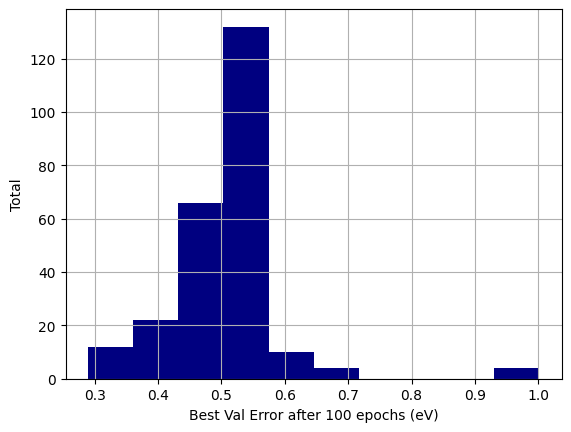

In [ ]:
plt.hist(best_val_error, color='navy')
plt.xlabel('Best Val Error after 100 epochs (eV)')
plt.ylabel('Total')
plt.grid(True)
plt.savefig(f'/drive/My Drive/archs-errors.png', dpi=500)
plt.show()